
# Trajectory Optimization for Cart-pole using DDP

## Importing neccessary libraries

In [1]:
import jdc
import numpy as np
import matplotlib.pyplot as plt
from time import time, sleep
from functools import partial
from jax.config import config
from diffrax import diffeqsolve, ODETerm, Dopri5 # jax's ode solver is fwd-mode not differentiable.
from pygame import K_s
from tabulate import tabulate
import pyqtgraph as pg
from pyqtgraph.Qt import QtCore


from jax import random
from jax import grad, jacrev, jit, lax, jacfwd
import jax.numpy as jnp
from jax import jit

config.update("jax_enable_x64", True) #enabling 64-bit floating points, high accuracy

## Switch plot background and foreground 
pg.setConfigOption('background', 'w')
pg.setConfigOption('foreground', 'k')

2022-07-12 19:20:26.958321: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-07-12 19:20:26.997828: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-07-12 19:20:27.001038: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-07-12 19:20:27.363749: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could no

pygame 2.1.2 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Why JAX ? 


## JAX is a high performance, numerical computing library has:

### 1. Automatic differentiation
        
- A set of techniques to evaluate the derivative of a function by applying the chain rule repeatedly to operations(addition,multiplication,sin,exp)


- Derivatives of arbitrary order can be computed automatically, accurately to working precision


- Evaluates derivatives at particular numeric values; it does not construct symbolic expressions for derivatives.

### 2. Just-in time compilation using XLA (Accelerated Linear Algebra) optimizing compiler

- Compiling bytecode into native machine code at run time


- Compiled code then directly executed without interpretation

### 3. Automatic Parallelization

- Across multiple CPU,GPU,TPU cores.

## Cart-pole Environment  

In [2]:
class CartPoleEnv():

    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 50}

    def __init__(self):
        
        #MODEL PARAMETERS
        self.gravity = 9.81
        self.masscart = 1
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5 
        self.polemass_length = self.masspole * self.length
        self.polemass_gravity = self.masspole * self.gravity
        
        #SAMPLE TIME
        self.tau = 0.02 
         
        #ODE SOLVER
        self.diffrax_solver = Dopri5()

        self.screen = None
        self.clock = None
        self.isopen = True
        self.state = None
        
        #SIM WINDOW SIZE
        self.x_threshold = 4

## State Transition Function

In [3]:
%load_ext itikz

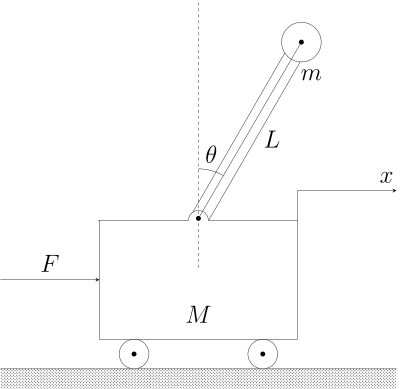

In [4]:
%%itikz --implicit-pic --scale=3.5
\usetikzlibrary{patterns}
\Huge{
% Angle of Pendulum
\newcommand{\ang}{30}
% ground
\draw [black] (-2,0) -- (2,0);
\fill [pattern = crosshatch dots,
    pattern color = black!80] (-2,0) rectangle (2,-.2);

% cart
\begin{scope} [draw = black,
    fill = white, 
    dot/.style = {black, radius = .025}]

\filldraw [rotate around = {-\ang:(0,1.5)}] (.09,1.5) -- 
    node [midway, right] {$L$} 
    node [very near end, right] {$m$}
    +(0,2) arc (0:180:.09) 
    coordinate [pos = .5] (T) -- (-.09,1.5);

\filldraw (-.65,.15) circle (.15);
\fill [dot] (-.65,.15) circle;
\filldraw (.65,.15) circle (.15);
\fill [dot] (.65,.15) circle;

\filldraw (-1,1.5) -- coordinate [pos = .5] (F)
    (-1,.3) -- node [above = .3cm] {$M$}
    (1,.3) -- (,1.5) 
    coordinate (X) -- (.1,1.5)
    arc (0:180:.1) -- (-1.014,1.5);

\fill [dot] (0,1.52) circle;
\filldraw (1.04,3.3) circle(0.2);
\fill [dot] (1.04,3.3) circle;
\end{scope}

% lines and angles
\begin{scope} [thin, black!50!black]
    \draw (T) -- (0,1.52) coordinate (P);
    \draw [dashed] (P) + (0,-.5) -- +(0,2.2);
    \draw (P) + (0,.5) arc (90:90-\ang:.5) node [black, midway, above] {$\theta$};
\end{scope}

% forces
    \draw [stealth-] (F) -- node [above] {$F$} + (-1,0);
    \draw [-stealth] (X) |- node [very near end, above right] {$x$} + (1,.3);}

$$ \Large{
\dot{\textbf{x}} \textbf{=}
    \begin{bmatrix}
        \dot{x} \\
        \ddot{x} \\
        \dot{\theta} \\
        \ddot{\theta} \\
    \end{bmatrix}
    \textbf{=}
    \begin{bmatrix}
        \dot{x} \\[1mm]
        \dfrac{F + m \sin(\theta)(L \dot{\theta}^2 - g \cos(\theta))} {M + m \sin(\theta)^2} \\[1mm]
        \dot{\theta} \\[1mm]
        \cfrac{-F \cos(\theta) - mL\theta^2  \sin(\theta) \cos(\theta) + (M +m) g \sin(\theta)}{L(M + m \sin(\theta)^2)}
    \end{bmatrix}} $$

In [6]:
%%add_to CartPoleEnv

@partial(jit, static_argnums=(0,))
def state_eq(self, t, state, u):
    x, x_dot, theta, theta_dot = state
    force = u[0]
    costheta, sintheta  = jnp.cos(theta), jnp.sin(theta)
    calc_den_help = self.masscart + (self.masspole * (sintheta**2))

    x_dot_dot = (
        force
        + self.polemass_length * sintheta * (theta_dot**2)
        - self.polemass_gravity * costheta * sintheta
    ) / calc_den_help
    theta_dot_dot = (
        -force * costheta
        - self.polemass_length * sintheta * costheta * (theta_dot**2)
        + self.total_mass * self.gravity * sintheta
    ) / (self.length * calc_den_help)

    return jnp.array([x_dot, 
                      x_dot_dot, 
                      theta_dot, 
                      theta_dot_dot])

## Next state by solving the ode

In [7]:
%%add_to CartPoleEnv

#x[i+1] = next_state(x[i])
def next_state(self, st, u):
    solution = diffeqsolve(
        ODETerm(self.state_eq),
        self.diffrax_solver,
        t0=0,
        t1=self.tau,
        dt0=self.tau,
        y0=st,
        args=u
    )
    return jnp.asarray(solution.ys[0]) 

## Initial state

In [8]:
%%add_to CartPoleEnv

def reset(self,x0=None):
    if x0 is not None:
        self.state = x0
    else:
        self.state = 2-4*jnp.squeeze(random.uniform(random.PRNGKey(int(time())), (4, 1)))
    return self.state

# go to next state
def step(self, control_input):
    state = self.state
    self.state = self.next_state(state, control_input)
    return self.state


# close simulation window
def close(self):
    if self.screen is not None:
        import pygame
        pygame.display.quit()
        pygame.quit()
        self.isopen = False

## Rendering the simulation

In [9]:
%%add_to CartPoleEnv
def render(self, mode="human"):    
    try:
        import pygame
        from pygame import gfxdraw
    except ImportError:
        raise DependencyNotInstalled("pygame is not installed, run `pip install gym[classic_control]`")
    screen_width =  1280
    screen_height = 720

    world_width = self.x_threshold * 2
    scale = screen_width / world_width
    polewidth = 20.0 
    polelen = scale * (3 * self.length)
    cartwidth = 100.0
    cartheight = 60.0
 
    if self.state is None:
        return None
    x = self.state
    
    if self.screen is None:
        pygame.init()
        pygame.display.init()
        self.screen = pygame.display.set_mode((screen_width, screen_height))
        
    if self.clock is None:
        self.clock = pygame.time.Clock()
        
    self.surf = pygame.Surface((screen_width, screen_height))
    self.surf.fill((238, 238, 238))
    
    l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
    axleoffset = cartheight / 4.0
    cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
    carty = 300  # TOP OF CART
    cart_coords = [(l, b), (l, t), (r, t), (r, b)]
    cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
    
    gfxdraw.hline(self.surf, 0, screen_width, carty, (48, 56, 65))

    gfxdraw.aapolygon(self.surf, cart_coords, (48, 56, 65))
    gfxdraw.filled_polygon(self.surf, cart_coords, (48, 56, 65))

    l, r, t, b = (
        -polewidth / 2,
        polewidth / 2,
        polelen - polewidth / 2,
        -polewidth / 2,
    )

    pole_coords = []
    for coord in [(l, b), (l, t), (r, t), (r, b)]:
        coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
        coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
        pole_coords.append(coord)
    gfxdraw.aapolygon(self.surf, pole_coords, (255, 87, 34))
    gfxdraw.filled_polygon(self.surf, pole_coords, (255, 87, 34))

    gfxdraw.aacircle(
        self.surf,
        int(cartx),
        int(carty + axleoffset),
        int(polewidth / 2),
        (0, 173, 181),
    )
    gfxdraw.filled_circle(
        self.surf,
        int(cartx),
        int(carty + axleoffset),
        int(polewidth / 2),
        (0, 173, 181),
    )      

    self.surf = pygame.transform.flip(self.surf, False, True)
    self.screen.blit(self.surf, (0, 0))
    if mode == "human":
        pygame.event.pump()
        self.clock.tick(self.metadata["render_fps"])

        pygame.display.flip()

    if mode == "rgb_array":
        return jnp.transpose(
            jnp.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
        )
    else:
        return self.isopen

## Model Validation

In [10]:
cartpole = CartPoleEnv()
sim_time = 600
u0 = jnp.array(jnp.zeros((sim_time, 1)))

cartpole.reset(jnp.array([0,0,jnp.pi/3,0]))
for t in range(sim_time):
    cartpole.render()
    x_pred = cartpole.step(u0[t])
cartpole.close()

## Class of DDP Algorithm

In [11]:
class DDP:
    def __init__(self, dyncst, x0, u0):
        next_state, running_cost, final_cost = dyncst
        self.x0 = x0
        self.u0 = u0
        self.n = x0.shape[0]  # state dimension
        self.N = u0.shape[0] + 1 # horizon
        self.regType = 2
        self.m = u0.shape[1]  # control input dimension

        self.maxIter = 500
        self.mu = 1
        self.dmu = 1 # delta
        self.muFactor = 2 # delta-not
        self.muMin = 1e-6
        self.muMax = 1e10 
        self.tau = 0.8
        self.tolFun = 1e-7
            
        # Auto-differentiation
        self.f = jit(next_state)
        self.l = jit(running_cost)
        self.lf = jit(final_cost)
        self.lf_x = jit(grad(self.lf))
        self.lf_xx = jit(jacfwd(self.lf_x))
        self.l_x = jit(grad(self.l, 0))
        self.l_u = jit(grad(self.l, 1))
        self.l_xx = jit(jacfwd(self.l_x, 0))
        self.l_uu = jit(jacfwd(self.l_u, 1))
        self.l_ux = jit(jacfwd(self.l_u, 0))
        self.f_x = jit(jacfwd(self.f, 0))
        self.f_u = jit(jacfwd(self.f, 1))
        self.f_xx = jit(jacfwd(self.f_x, 0))
        self.f_uu = jit(jacfwd(self.f_u, 1))
        self.f_ux = jit(jacfwd(self.f_u, 0))
            
        self.init_plots(3)

In [12]:
class DDP(DDP):
    
    def init_plots(self,num_plots):
        self.win = pg.GraphicsLayoutWidget(show=True,size=(1080,360))
        # Enable antialiasing for prettier plots
        self.win.setWindowTitle('Trajectory optimization for cart-pole with DDP')
        pg.setConfigOptions(antialias=True)
        self.plts = [self.win.addPlot(row=0,col=i) for i in range(num_plots)]

        colors = ['b', 'r', 'k']
        self.curves = [self.plts[i].plot(pen=pg.mkPen(colors[i],width=2)) for i in range(num_plots)]

        labels = ['Cost','Lambda','Alpha']
        for i,lbl in enumerate(labels):
            self.plts[i].setLabel('left', lbl)
            self.plts[i].setLabel('bottom', 'Iteration')
        self.data = [[] for i in range(num_plots)]

    def update_plots(self,cost,lmbda,alpha):
        
        yy = [cost, lmbda, alpha]
        for k, y in enumerate(yy):
            self.data[k].append(yy[k])
            self.curves[k].setData(jnp.hstack(self.data[k]))
        pg.QtWidgets.QApplication.processEvents()

## Checking positive definitess using Cholesky Decomposition

In [13]:
class DDP(DDP):
    
    @partial(jit, static_argnums=(0,))
    def is_pos_def(self, x):
        return jnp.all(jnp.diagonal(jnp.linalg.cholesky(x)) > 0)

## Backward-pass

In [14]:
class DDP(DDP):
    
    @partial(jit, static_argnums=(0,))
    def backward_pass(self, x_seq, u_seq, lmbda):
        
        k_seq = jnp.array(jnp.zeros((self.N - 1, self.m)))
        kk_seq = jnp.array(jnp.zeros((self.N - 1, self.n)))
        dV = jnp.array([0.0, 0.0])
        V = jnp.zeros(self.N)  # cost-to-go
        V_x = jnp.array(jnp.zeros((self.N, self.n)))
        V_xx = jnp.array(jnp.zeros((self.N, self.n, self.n)))
        V_xx_reg = jnp.array(jnp.zeros((self.N, self.n, self.n)))

        # Initiliazation to be started from N
        V = V.at[-1].set(self.lf(x_seq[-1]))
        V_x = V_x.at[-1].set(self.lf_x(x_seq[-1]))
        V_xx = V_xx.at[-1].set(self.lf_xx(x_seq[-1]))
   
        def backward_loop_cond(carry):
            # these needs to be carried for jax to track
            i, x, u, v_x, v_xx, v_xx_reg, _, _, _ = carry
            f_u_i = self.f_u(x[i], u[i])
            v_xx_reg = v_xx_reg.at[i + 1].set(
                v_xx[i + 1] + lmbda * jnp.eye(self.n) * (self.regType == 1)
            )
            f_u_T_v_xx_reg = f_u_i.T @ v_xx_reg[i + 1]

            q_uu_reg = (
                self.l_uu(x[i], u[i])
                + f_u_T_v_xx_reg @ f_u_i
                + lmbda * (self.regType == 2)
                + jnp.tensordot(v_x[i + 1], jnp.squeeze(self.f_uu(x[i], u[i])),axes=1)
            )
            return self.is_pos_def(q_uu_reg) & (i >= 0)

        def backward_loop_body(carry):
            # these needs to be carried for jax to track
            i, x, u, v_x, v_xx, v_xx_reg, k, kk, dv = carry
            f_x_i = self.f_x(x[i], u[i])
            f_u_i = self.f_u(x[i], u[i])
            q_x = self.l_x(x[i], u[i]) + f_x_i.T @ v_x[i + 1]
            q_u = self.l_u(x[i], u[i]) + f_u_i.T @ v_x[i + 1]
            q_xx = (
                self.l_xx(x[i], u[i])
                + (f_x_i.T @ v_xx[i + 1]) @ f_x_i
                + jnp.tensordot(v_x[i + 1], jnp.squeeze(self.f_xx(x[i], u[i])),axes=1)
            )

            f_u_T_v_xx = f_u_i.T @ v_xx[i + 1]

            q_ux = (
                self.l_ux(x[i], u[i])
                + f_u_T_v_xx @ f_x_i
                + jnp.tensordot(v_x[i + 1], jnp.squeeze(self.f_ux(x[i], u[i])),axes=1)
            )

            q_uu = (
                self.l_uu(x[i], u[i])
                + f_u_T_v_xx @ f_u_i
                + jnp.tensordot(v_x[i + 1], jnp.squeeze(self.f_uu(x[i], u[i])),axes=1)
            )

            v_xx_reg = v_xx_reg.at[i + 1].set(
                v_xx[i + 1] + lmbda * jnp.eye(self.n) * (self.regType == 1)
            )
            f_u_T_v_xx_reg = f_u_i.T @ v_xx_reg[i + 1]

            q_ux_reg = (
                self.l_ux(x[i], u[i])
                + f_u_T_v_xx_reg @ f_x_i
                + jnp.tensordot(v_x[i + 1], jnp.squeeze(self.f_ux(x[i], u[i])),axes=1)
            )

            q_uu_reg = (
                self.l_uu(x[i], u[i])
                + f_u_T_v_xx_reg @ f_u_i
                + lmbda * (self.regType == 2)
                + jnp.tensordot(v_x[i + 1], jnp.squeeze(self.f_uu(x[i], u[i])),axes=1)
            )
            inv_q_uu_reg = jnp.linalg.inv(q_uu_reg)
            k_i = -inv_q_uu_reg @ q_u
            kk_i = -inv_q_uu_reg @ q_ux_reg

            dv += jnp.array([k_i.T @ q_u, 0.5 * (k_i.T @ q_uu) @ k_i])

            kk_i_q_uu = kk_i.T @ q_uu
            v_x = v_x.at[i].set(q_x + kk_i_q_uu @ k_i + kk_i.T @ q_u + q_ux.T @ k_i)
            v_xx = v_xx.at[i].set(
                q_xx + kk_i_q_uu @ kk_i + kk_i.T @ q_ux + q_ux.T @ kk_i
            )
            v_xx = v_xx.at[i].set(0.5 * (v_xx[i].T + v_xx[i]))
            k = k.at[i].set(k_i)
            kk = kk.at[i].set(kk_i[0])

            return i - 1, x, u, v_x, v_xx, v_xx_reg, k, kk, dv

        seqs_all = lax.while_loop(
            backward_loop_cond,
            backward_loop_body,
            init_val=(self.N - 1, x_seq, u_seq, V_x, V_xx, V_xx_reg, k_seq, kk_seq, dV),
        )
    
        k_seq = seqs_all[6]
        kk_seq = seqs_all[7]
        dv = seqs_all[8]
        diverge = seqs_all[0] + 1 # if i != 0: divergence occured which why while loop ended

        return k_seq, kk_seq, dv, diverge

## Forward-pass

In [15]:
class DDP(DDP):
    
    @partial(jit, static_argnums=(0,))
    def forward_pass(self, x_seq, u_seq, k_seq, kk_seq, alpha):
        x_seq_hat = jnp.array(jnp.zeros(x_seq.shape))
        x_seq_hat = x_seq_hat.at[0].set(self.x0)
        u_seq_hat = jnp.array(jnp.zeros(u_seq.shape))
        
        def forward_loop(i, seqs):
            x_hat, u_hat, x, u, k, kk = seqs
            control = alpha * k[i] + kk[i] @ (x_hat[i] - x[i])
            u_hat = u_hat.at[i].set(u[i] + control[0])
            x_hat = x_hat.at[i + 1].set(self.f(x_hat[i], u_hat[i]))
            return x_hat, u_hat, x, u, k, kk

        seqs_all = lax.fori_loop(0,self.N - 1,
                                 forward_loop,
                                 (x_seq_hat, u_seq_hat, x_seq, u_seq, k_seq, kk_seq))
        
        return seqs_all[0], seqs_all[1]  # x_seq_hat, u_seq_hat

In [16]:
class DDP(DDP):
    def run_iteration(self):
        # initilization of the sequences
        x_seq = jnp.empty((self.N, self.n))
        x_seq = x_seq.at[0].set(self.x0)
        u_seq = self.u0
        k_seq = jnp.array(jnp.zeros((self.N - 1, self.m)))
        kk_seq = jnp.array(jnp.zeros((self.N - 1, self.n)))

        x_seq, _ = self.forward_pass(x_seq, u_seq, k_seq, kk_seq, 1)

        cost = self.l(x_seq, u_seq) + self.lf(x_seq[-1])  # initial cost
        dcost = 0.0  # initialize reduction in cost

        mu = self.mu
        dmu = self.dmu
        muFactor = self.muFactor
        muMin = self.muMin
        muMax = self.muMax
        Alpha = self.tau ** (jnp.linspace(0, 50, 51))

        for i in range(self.maxIter):

            back_pass_done = False
            backward_start = time()

            while not back_pass_done:
                
                k_seq, kk_seq, dv, diverge = self.backward_pass(x_seq, u_seq, mu)
                
                if diverge:
                    dmu = max(dmu * muFactor, muFactor)
                    mu = max(mu * dmu, muMin)

                    if mu > muMax:
                        print("mu reached to the maximum (%s)", muMax)
                        break
                else:
                    back_pass_done = True

            backward_finish = time() - backward_start

            fwd_pass_done = False
            if back_pass_done:
                fwd_start = time()
                for alpha in Alpha:
                    x_new, u_new = self.forward_pass(x_seq, u_seq, k_seq, kk_seq, alpha)
                    
                    running_cost_new = self.l(x_new, u_new)
                    final_cost_new = self.lf(x_new[-1])
                    
                    cost_new = running_cost_new + final_cost_new
                    dcost = cost - cost_new
                    expected = -alpha * (dv[0] + alpha * dv[1])
                    
                    if expected > 0:
                        z = dcost / expected
                    else:
                        z = jnp.sign(dcost)
                    if z > 0:
                        fwd_pass_done = True
                        break

                fwd_finish = time() - fwd_start

            if fwd_pass_done:

                # decrease mu
                dmu = min(dmu / muFactor, 1 / muFactor)
                mu = mu * dmu * (mu > muMin)

                # accept changes
                cost = cost_new
                x_seq = x_new
                u_seq = u_new

                self.update_plots(cost,mu,alpha)

                print("\n",tabulate([[i,cost_new,running_cost_new,final_cost_new,dcost,(fwd_finish + backward_finish),
                            ]],
                        headers=["iter","J","l","lf","reduction","in (s)",],),)

                if dcost < self.tolFun:
                    print("SUCCESS: cost reduction < tolFun '(%s)' " % self.tolFun)
                    break

            else:  # no cost improvement
                # increase mu
                dmu = max(dmu * muFactor, muFactor)
                mu = max(mu * dmu, muMin)

                # terminate ?
                if mu > muMax:
                    print("mu reached to the maximum (%s)", muMax)
                    break
            if i == self.maxIter:
                print("Maximum number of Iteration: %d is done, cost is still reducing.", i)

        return x_seq, u_seq


## Running the Iteration

### Desiging Cost

$$ \Large{
    \ell (\textrm{x}, \textrm{u}) = \frac{1}{2} \textrm{u}^T R \textrm{u}, \ \ R = 0.01 \\[10mm]
    \ell_f(\textrm{x}_N) = \frac{1}{2}
    (\textrm{x}_N - \textrm{x}_{target})^T Q (\textrm{x}_{N} -  \textrm{x}_{target})\\[10mm] Q= 
    \begin{bmatrix}
    100 & 0 & 0 &  0 \\
    0 & 1 & 0 & 0\\
    0 & 0 & 100 & 0 \\
    0 & 0 & 0 & 1
    \end{bmatrix} \\[10mm] \textrm{x}_{target} = [2\ 0\ 0\ 0]^T \\[10mm] \textrm{x}_{0} = [-2\ 0\ \pi\ 0]^T \\[10mm]  \bar{\textrm{U}}_{0_i} \in [-1,1] } $$ 



In [17]:
cartpole = CartPoleEnv()

x0 = cartpole.reset(jnp.array([-2,0,jnp.pi,0]))
pred_time = 100 #N
u0 = 1 - 2*random.uniform(random.PRNGKey(int(time())),
                          (pred_time - 1, 1))
  
def next_state(x, u):
    return cartpole.next_state(x, u) #f(x(i), u(i))

def running_cost(x, u):
    return 0.5*0.01*jnp.sum(jnp.square(u)) # l(x, u)

def final_cost(x):
    return 0.5*(100*jnp.square(2 - x[0]) 
                   + jnp.square(x[1])
                   + 100*jnp.square(x[2])
                   + jnp.square(x[3]))  # lf(x)

In [18]:
ddp = DDP([next_state, running_cost, final_cost], x0, u0)   

x_seq, u_seq = ddp.run_iteration()


(python3:10968): Gtk-WARNING **: 19:22:15.972: GTK+ module /usr/lib/x86_64-linux-gnu/gtk-2.0/modules/libgail.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 19:22:15.973: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.



   iter        J        l       lf    reduction    in (s)
------  -------  -------  -------  -----------  --------
     0  455.293  1.88912  453.404      856.916   37.6277

   iter        J        l       lf    reduction    in (s)
------  -------  -------  -------  -----------  --------
     1  181.356  6.47064  174.885      273.937   37.6287

   iter        J        l       lf    reduction     in (s)
------  -------  -------  -------  -----------  ---------
     2  45.7434  16.6918  29.0516      135.612  0.0119872

   iter        J        l       lf    reduction      in (s)
------  -------  -------  -------  -----------  ----------
     3  33.7288  17.0314  16.6974      12.0146  0.00896049

   iter      J       l     lf    reduction     in (s)
------  -----  ------  -----  -----------  ---------
     4  30.91  20.968  9.942      2.81877  0.0138574

   iter        J        l       lf    reduction      in (s)
------  -------  -------  -------  -----------  ----------
     5  19.2991  1

In [19]:
ddp.win.close()


## Optimal State Trajectory and Control Input

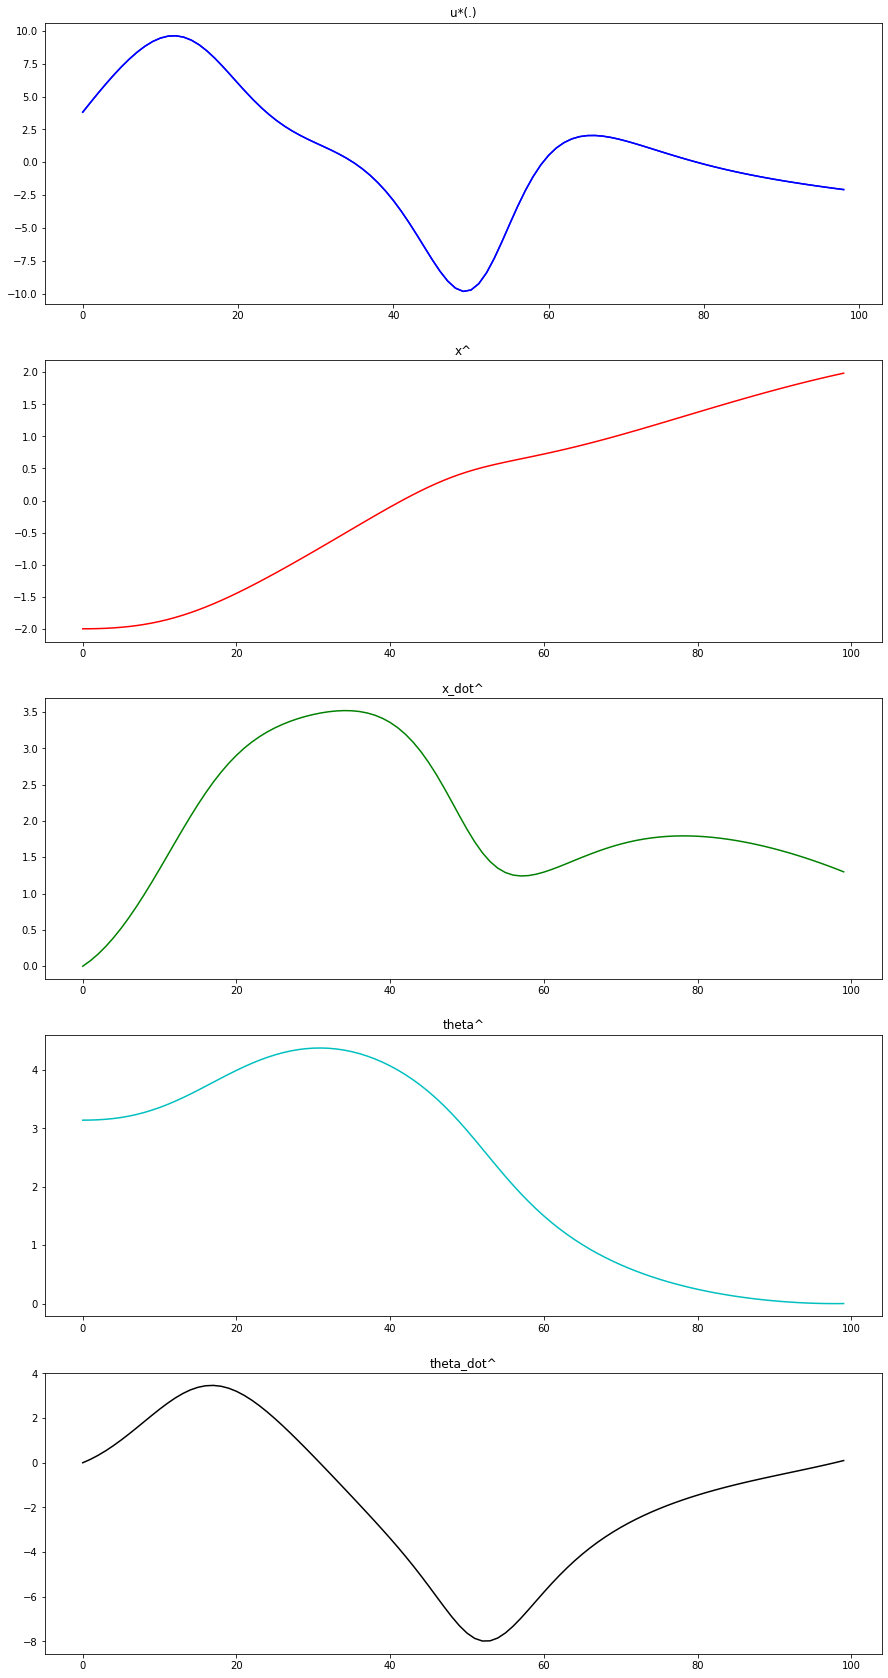

In [21]:
fig, axs = plt.subplots(5, 1,figsize=(15,30))
axs[0].plot(u_seq[:, 0], "b")
titles = ["u*(.)", "x^", "x_dot^", "theta^", "theta_dot^"]
colors = ["b", "r", "g", "c", "k"]
for i in range(5): 
    axs[i].set_title(titles[i])
    if i == 0:
        axs[i].plot(u_seq[:, 0], colors[i])
    else:
        axs[i].plot(x_seq[:, i - 1], colors[i])
plt.show(block=True)

## Simulation of the Optimal policy

In [29]:
cartpole.reset(x0)
for t in range(pred_time):
    cartpole.render()
    
    x_pred = cartpole.step(u_seq[t])


   iter       J         l      lf    reduction    in (s)
------  ------  --------  ------  -----------  --------
     0  833.47  0.310575  833.16      281.679   38.1361

   iter        J        l       lf    reduction    in (s)
------  -------  -------  -------  -----------  --------
     1  485.179  1.09503  484.084      348.291    40.546

   iter        J        l       lf    reduction     in (s)
------  -------  -------  -------  -----------  ---------
     2  130.564  2.51711  128.047      354.615  0.0088675

   iter        J        l       lf    reduction     in (s)
------  -------  -------  -------  -----------  ---------
     3  28.6099  3.77003  24.8398      101.954  0.0129027

   iter        J        l       lf    reduction      in (s)
------  -------  -------  -------  -----------  ----------
     4  7.80991  4.40205  3.40786         20.8  0.00987482

   iter        J        l      lf    reduction      in (s)
------  -------  -------  ------  -----------  ----------
     5  

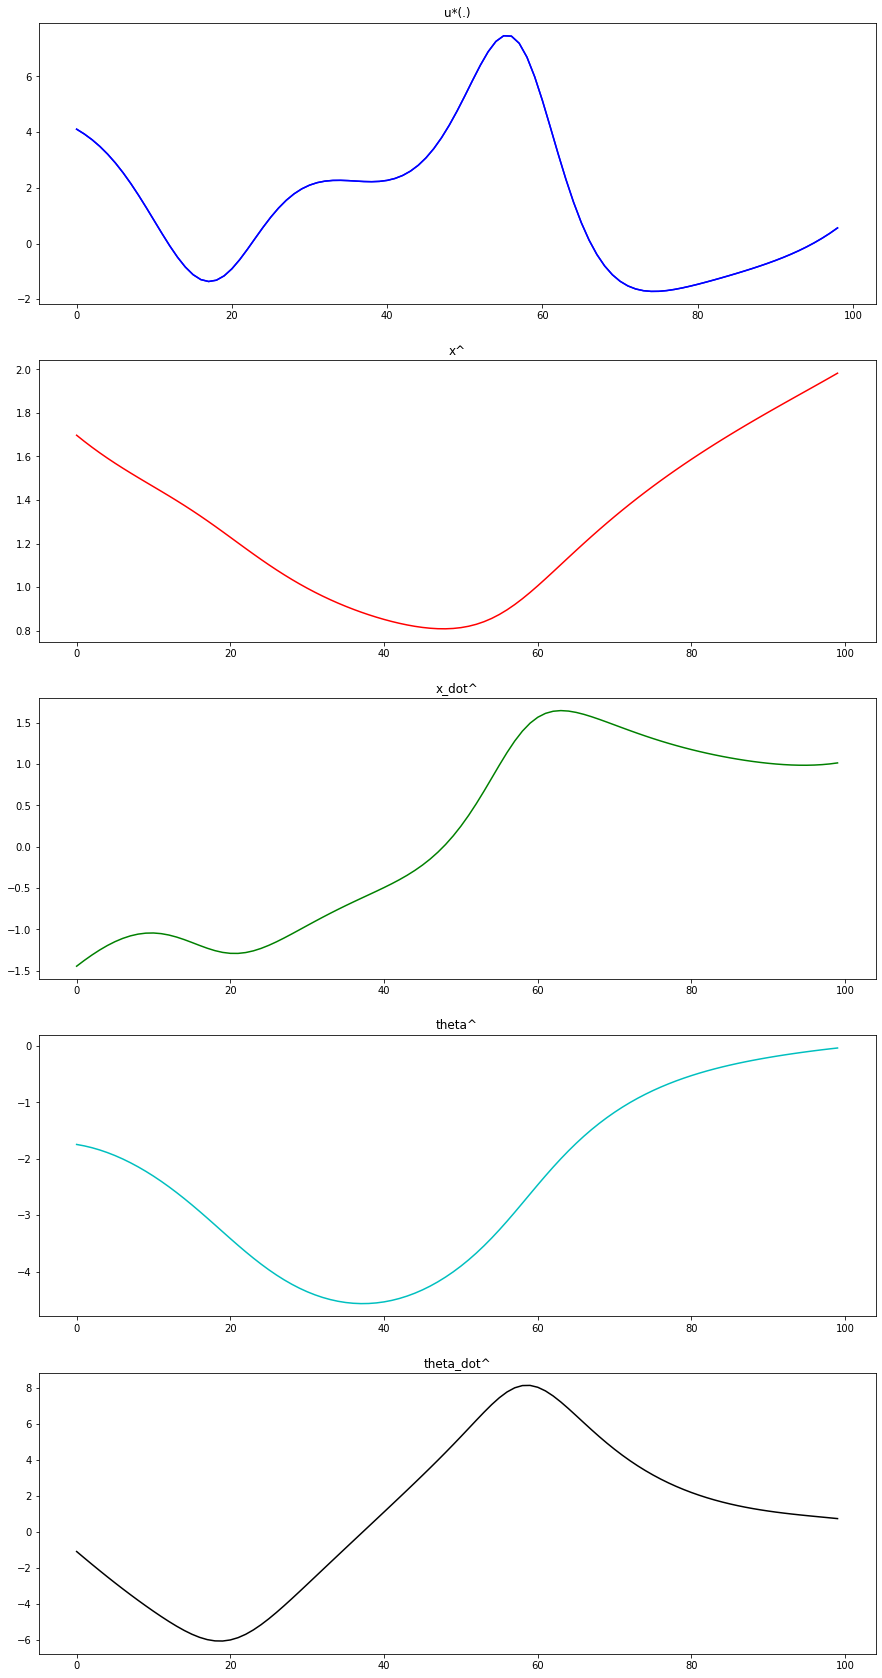

In [30]:
x0 = cartpole.reset()

ddp = DDP([next_state, running_cost, final_cost], x0, u0)   

x_seq, u_seq = ddp.run_iteration()

fig, axs = plt.subplots(5, 1,figsize=(15,30))
axs[0].plot(u_seq[:, 0], "b")
titles = ["u*(.)", "x^", "x_dot^", "theta^", "theta_dot^"]
colors = ["b", "r", "g", "c", "k"]
for i in range(5): 
    axs[i].set_title(titles[i])
    if i == 0:
        axs[i].plot(u_seq[:, 0], colors[i])
    else:
        axs[i].plot(x_seq[:, i - 1], colors[i])
plt.show(block=True)

In [31]:
ddp.win.close()

## Random initial state

In [38]:
cartpole.reset(x0)
for t in range(pred_time):
    cartpole.render()
    x_pred = cartpole.step(u_seq[t])

In [25]:
cartpole.close()